# stocks X sentiment analysis dataset
this notebook idea is to do sentiment analysis about socks related tweets and check the correlation between 
these tweets and the actual stocks prices, and to check if we can predict stocks changes by the tweets



In [ ]:
# !pip install kaggle
# before using kaggle commands put kaggle.json token file in user directory
# import zipfile
# !kaggle datasets download -d equinxx/stock-tweets-for-sentiment-analysis-and-prediction

# z= zipfile.ZipFile('stock-tweets-for-sentiment-analysis-and-prediction.zip')
# z.extractall()


  0%|          | 0.00/6.59M [00:00<?, ?B/s]
 15%|█▌        | 1.00M/6.59M [00:01<00:05, 979kB/s]
 30%|███       | 2.00M/6.59M [00:01<00:03, 1.41MB/s]
 45%|████▌     | 3.00M/6.59M [00:02<00:02, 1.59MB/s]
 61%|██████    | 4.00M/6.59M [00:02<00:01, 1.52MB/s]
 76%|███████▌  | 5.00M/6.59M [00:03<00:01, 1.59MB/s]
 91%|█████████ | 6.00M/6.59M [00:04<00:00, 1.61MB/s]
100%|██████████| 6.59M/6.59M [00:04<00:00, 1.66MB/s]
100%|██████████| 6.59M/6.59M [00:04<00:00, 1.55MB/s]


## imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

style.use('ggplot')
# nlp
import re
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer# classification
nltk.download('vader_lexicon')

# deep learning
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Explore the overall datasets

In [ ]:
tweets = pd.read_csv('stock_tweets.csv')

# changing col names
tweets.rename(columns = {'Date':'date','Tweet':'tweet'}, inplace=True)

tweets

,date,tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          80793 non-null  object
 1   tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


## Check the companies we working with

In [ ]:

tweets["Stock Name"].unique(),"",tweets["Company Name"].unique()


(array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
        'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
        'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object),
 '',
 array(['Tesla, Inc.', 'Microsoft Corporation', 'Procter & Gamble Company',
        'Meta Platforms, Inc.', 'Amazon.com, Inc.', 'Alphabet Inc.',
        'Advanced Micro Devices, Inc.', 'Apple Inc.', 'Netflix, Inc.',
        'Taiwan Semiconductor Manufacturing Company Limited',
        'The Coca-Cola Company', 'Ford Motor Company',
        'Costco Wholesale Corporation', 'The Walt Disney Company',
        'Verizon Communications Inc.', 'Salesforce, Inc.',
        'Intel Corporation', 'The Boeing Company', 'Blackstone Inc.',
        'Northrop Grumman Corporation', 'PayPal Holdings, Inc.',
        'Enphase Energy, Inc.', 'NIO Inc.', 'Zscaler, Inc.', 'XPeng Inc.'],
       dtype=object))

In [ ]:
# do simple tokenizing and calculate the S/W ratio
tokenized = tweets.tweet.apply(lambda r: [w for w in r.split()])
tweets.shape[0] / tokenized.apply(lambda e: len(e)).values.mean()


2950.3118214348506

## check each company occurances counts in the data

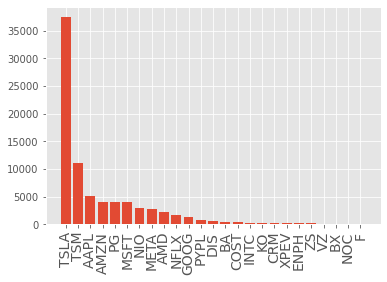

In [ ]:
# check each company occurances counts in the data
counts_df = tweets.groupby(['Stock Name']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)
style.use('ggplot')
plt.bar(counts_df["Stock Name"].values,counts_df["counts"].values)
plt.xticks(fontsize=14, rotation=90)
plt.show()

## keep only stocks with high number of samples (>1500) # dont

In [ ]:
# keep_list = counts_df[counts_df['counts'] > 1500]['Stock Name'].values
# keep_list
# tweets = tweets[tweets['Stock Name'].isin(keep_list)]

tweets['date'] = pd.to_datetime(tweets['date']) 
tweets['date'] = tweets['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
tweets['date'] = pd.to_datetime(tweets['date']) 
tweets.head()
# counts_df

,date,tweet,Stock Name,Company Name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
stocks = pd.read_csv('stock_yfinance_data.csv')
# stocks = stocks[stocks['Stock Name'].isin(keep_list)]
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


# Work with tesla data only

In [ ]:
tweets = tweets[tweets['Stock Name'] == 'TSLA']
stocks = stocks[stocks['Stock Name'] == 'TSLA']

tweets.shape, stocks.shape

((37422, 4), (252, 8))

## Classify tweets

In [ ]:
clf = SentimentIntensityAnalyzer()
tweets['compund'] = tweets['tweet'].apply(lambda e: clf.polarity_scores(e)['compound'])

<ipython-input-11-0e53eea50a5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['compund'] = tweets['tweet'].apply(lambda e: clf.polarity_scores(e)['compound'])


## Show Tesla close values during the given data

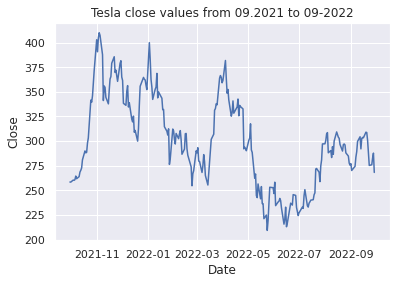

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
l = sns.lineplot(x="Date", y="Close",
             data=stocks)
l.set(title='Tesla close values from 09.2021 to 09-2022')
l
# fig, ax = plt.subplots()
# ax.plot(stocks['Date'], stocks['Close'])
# ax.set_title('Tesla close values from 09.2021 to 09-2022')
# ax.scatter([x for x in range(10)], [y for y in range(10)])

## Assign each sampple from tweets to the closes date in stocks dates and calculate the mean compound value for each date group(there are 252 date groups)

In [ ]:
# tweets.head()

stocks_dates = stocks['Date']
def get_distance(d_time):
    return abs(d_time.days)

def get_closest(e):
    # dist = np.min(stocks_dates.apply(lambda x: abs((e-x).days)))
    # return stocks_dates[stocks_dates==dist]

    return min(stocks_dates, key= lambda x: get_distance(x-e))

tweets['closes_date'] = tweets['date'].apply(get_closest)

compound_means = tweets.groupby(by=['closes_date']).mean().reset_index()# col1= date, col2=compund_mean
compound_means.head()
# (pd.Timestamp('2022-09-30') - pd.Timestamp('2022-09-29')) > (pd.Timestamp('2022-09-30') - pd.Timestamp('2022-09-30'))

In [ ]:
compound_means.head()

,closes_date,compund
0,2021-09-30,0.231552
1,2021-10-01,0.254797
2,2021-10-04,0.181539
3,2021-10-05,0.069445
4,2021-10-06,0.199940


## Merge the two sets, such that each date from stocks dataset get the relevant compund mean of its group as a new column. And then save the result in stocks_with_emotion.csv

In [ ]:

merged_sets = stocks.merge(
    compound_means,
    how = 'inner',
    left_on = 'Date',
    right_on = 'closes_date',
)

merged_sets.to_csv('stocks_with_emotion.csv', index=False)

NameError: ignored

# Analyze the stocks and compound combination dataset

Now we will work on the new dataset that we saved in stocks_with_emotion.csv and will analyze and build a model to predict Tesla stocks behavior based on the data we saved from the previous session

In [3]:
dataset = pd.read_csv('stocks_with_emotion.csv', index_col=False)
dataset.rename(columns={'compund': 'compound'}, inplace=True)
dataset['Date'] = pd.to_datetime(dataset['Date']) 

In [4]:
dataset.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,closes_date,compound
0,0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,2021-09-30,0.231552
1,1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,2021-10-01,0.254797
2,2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,2021-10-04,0.181539
3,3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,2021-10-05,0.069445
4,4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,2021-10-06,0.199940


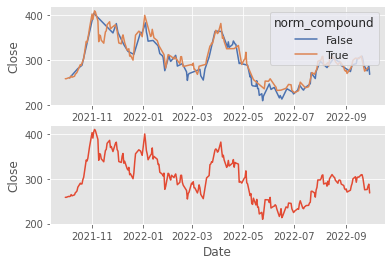

In [5]:
mini = dataset['compound'].min()
maxi = dataset['compound'].max()

dataset['norm_compound'] = dataset['compound'].apply(lambda e: (e-mini)/(maxi-mini))
dataset['norm_compound'] = dataset['norm_compound'] > 0.5
f, axes = plt.subplots(2, 1)
sns.set_theme(style="darkgrid")
sns.lineplot(data=dataset, x="Date", y="Close", hue='norm_compound', ax=axes[0])
sns.lineplot(data=dataset, x="Date", y="Close",ax=axes[1])

## Prepare the data to train and test

In [6]:
x_data = dataset[['Date','Open','compound']]
y_data = dataset[['Close']]

x_data[['day','month','year']] = np.zeros((x_data.shape[0],3))

# dataset.iloc[0]['Date']
def update_dates(r):
    r['day'] = r['Date'].day
    r['month'] = r['Date'].month
    r['year'] = r['Date'].year
    return r

x_data = x_data.apply(update_dates, axis=1)
x_data.drop(['Date'], axis=1, inplace=True)

# normalize compound value
x_data['compound'] = (x_data['compound'] - x_data['compound'].mean())/x_data['compound'].std()
x_data['Open'] = (x_data['Open'] - x_data['Open'].mean())/x_data['Open'].std()

x_data[['open(-1)','open(-2)','open(-3)', 'open(-4)', 'open(-5)']] = np.zeros((x_data.shape[0],5))
for i in range(x_data.shape[0]):
    try:
        for j in range(1,6):
            x_data.loc[i, f'open(-{j})'] = x_data.loc[i-j, 'Open']

    except:
        continue

x_data.head(7)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Open,compound,day,month,year,open(-1),open(-2),open(-3),open(-4),open(-5)
0,-0.865711,1.346849,30,9,2021,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.884486,1.775066,1,10,2021,-0.865711,0.000000,0.000000,0.000000,0.000000
2,-0.753785,0.425487,4,10,2021,-0.884486,-0.865711,0.000000,0.000000,0.000000
3,-0.838271,-1.639535,5,10,2021,-0.753785,-0.884486,-0.865711,0.000000,0.000000
4,-0.900373,0.764473,6,10,2021,-0.838271,-0.753785,-0.884486,-0.865711,0.000000
5,-0.833505,0.628304,7,10,2021,-0.900373,-0.838271,-0.753785,-0.884486,-0.865711
6,-0.755879,1.801130,8,10,2021,-0.833505,-0.900373,-0.838271,-0.753785,-0.884486


In [ ]:
x_data = x_data[['Open', 'day', 'month', 'year', 'compound']]

### split to test and train

In [ ]:
split = int(0.8 * dataset.shape[0])
x_train,y_train = x_data[:split], y_data[:split]
x_test,y_test = x_data[split::], y_data[split::]
# x_data.shape, y_data.shape
# int(0.8*252)

## Build NN regression model

In [ ]:
x_train.shape

(201, 5)

In [ ]:

# x_train = np.array(x_train)
# x_train = np.expand_dims(x_train, axis=0)
# inputs = np.expand_dims(x_train.values, axis=-1)
x_test = np.expand_dims(x_test.values, axis=-1)
x_train = np.expand_dims(x_train.values, axis=-1)
# # x_train = np.array([[i] for i in x_train])
# # x_train.shape
# inputs.shape

# data = np.random.rand(2, 3)
# data = data.reshape((1,2,3))
# inputs[]
x_test.shape

(51, 10, 1)

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(64,kernel_initializer='normal',input_shape=(None,5), activation='selu'))
NN_model.add(Dense(64, kernel_initializer='normal',activation='selu'))
NN_model.add(Dense(32, kernel_initializer='normal',activation='selu'))
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, None, 64)          384       
                                                                 
 dense_25 (Dense)            (None, None, 64)          4160      
                                                                 
 dense_26 (Dense)            (None, None, 32)          2080      
                                                                 
 dense_27 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = NN_model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, verbose = 2)


Epoch 1/500


5/5 - 1s - loss: 99766.3516 - mean_squared_error: 99766.3516 - val_loss: 48535.3281 - val_mean_squared_error: 48535.3281 - 1s/epoch - 210ms/step
Epoch 2/500
5/5 - 0s - loss: 91716.1641 - mean_squared_error: 91716.1641 - val_loss: 42517.5625 - val_mean_squared_error: 42517.5625 - 60ms/epoch - 12ms/step
Epoch 3/500
5/5 - 0s - loss: 81735.3594 - mean_squared_error: 81735.3594 - val_loss: 33579.7852 - val_mean_squared_error: 33579.7852 - 43ms/epoch - 9ms/step
Epoch 4/500
5/5 - 0s - loss: 66466.2344 - mean_squared_error: 66466.2344 - val_loss: 21143.6836 - val_mean_squared_error: 21143.6836 - 77ms/epoch - 15ms/step
Epoch 5/500
5/5 - 0s - loss: 45591.8086 - mean_squared_error: 45591.8086 - val_loss: 7368.2974 - val_mean_squared_error: 7368.2974 - 45ms/epoch - 9ms/step
Epoch 6/500
5/5 - 0s - loss: 21257.3848 - mean_squared_error: 21257.3848 - val_loss: 130.1581 - val_mean_squared_error: 130.1581 - 72ms/epoch - 14ms/step
Epoch 7/500
5/5 - 0s - loss: 3847.1426 - mean_squared_error: 3847.1426 - 

In [ ]:
NN_model.predict(x_test)
# x_test.shape

## plot performance

2/2 [==============================] - 0s 5ms/step


<ipython-input-84-9761806554b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['preds'] = NN_model.predict(x_test)


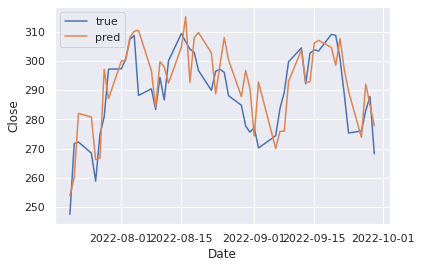

In [ ]:
# dataset.shape

validate = dataset.iloc[split::]
# validate.shape
validate['preds'] = NN_model.predict(x_test)
# # validate.head()
# # # validate['preds'] -= 30
fig, ax = plt.subplots()
sns.lineplot(x='Date', y='Close', data=validate, label="true")
sns.lineplot(x='Date', y='preds', data=validate, label='pred')


2/2 [==============================] - 0s 6ms/step


<ipython-input-85-9c16c629cdc4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['preds2'] =  [i[0] for i in (list(NN_model.predict(x_train)) + list(NN_model.predict(x_test)))]


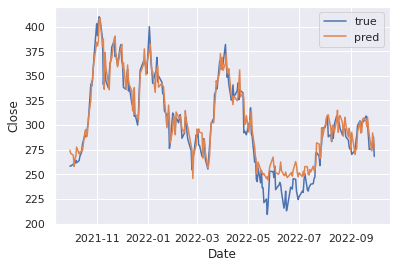

In [ ]:
# dataset.shape

validate = dataset.iloc[0::]
# validate.shape
validate['preds2'] =  [i[0] for i in (list(NN_model.predict(x_train)) + list(NN_model.predict(x_test)))]
# # validate.head()
# # # validate['preds'] -= 30
fig, ax = plt.subplots()
sns.lineplot(x='Date', y='Close', data=validate, label="true")
sns.lineplot(x='Date', y='preds2', data=validate, label='pred')

## Showing the learning rate (by MSE)

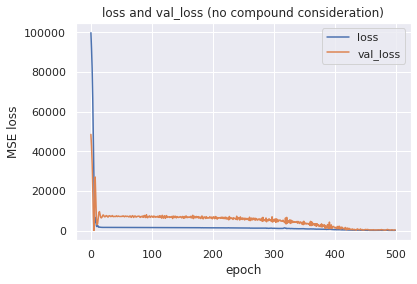

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],  label='val_loss')
plt.title('loss and val_loss (no compound consideration)')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()

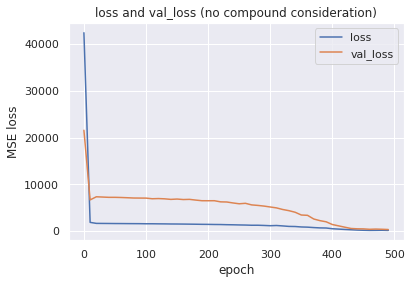

In [ ]:
# plt.plot(history.history['loss'])
loss10 = []
for i in range(0, len(history.history['loss']), 10):
    loss10.append(np.mean(history.history['loss'][i: i+10]))

val_loss10 = []
for i in range(0, len(history.history['val_loss']), 10):
    val_loss10.append(np.mean(history.history['val_loss'][i: i+10]))

epochs_n = [i*10 for i in range(50)]
plt.plot(epochs_n, loss10, label='loss')
plt.plot(epochs_n,val_loss10,  label='val_loss')
plt.title('loss and val_loss (no compound consideration)')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()

# plt.plot(history.history['val_mean_squared_error'])


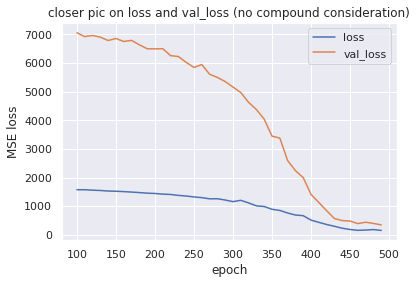

In [ ]:
z = 10
plt.plot(epochs_n[z::], loss10[z::], label='loss')
plt.plot(epochs_n[z::],val_loss10[z::],  label='val_loss')
plt.title('closer pic on loss and val_loss (no compound consideration)')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()

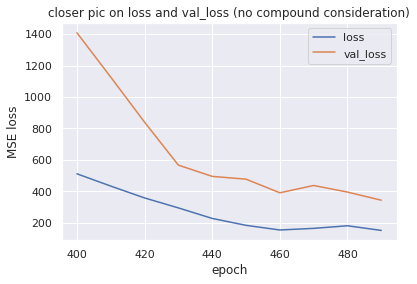

In [ ]:
z = 40
plt.plot(epochs_n[z::], loss10[z::], label='loss')
plt.plot(epochs_n[z::],val_loss10[z::],  label='val_loss')
plt.title('closer pic on loss and val_loss (no compound consideration)')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()

#Conclusion

The model with the compound value has more stable learning rate plot, unlike the model without the compound value its learning rate plot had a high variance and it semmed like it has some randomness with it.
So we conclude that compound value, which is the tweets emotions scale, has a potential to affect the stocks values.